# <center>MACHINE LEARNING <br> <br> L7b <br> Linear Regression and Regularisation</center>

Name: Guillem Escriba Molto

NIA: 242123

In [ ]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.axes3d import Axes3D

In [ ]:
def constructDesignMatrix1D(x,deg):
    X = np.ones(x.shape)

    for i in range(deg):
        X = np.hstack((X,x**(i+1)))

    return X

def computeError(X,y,w):
    # computeCost : average sum of squares error. Expects
    #     X : NxD design matrix
    #     t : Nx1 target response variable
    #     theta : model parameters
    N = len(y)
    aux = np.dot(X,w) - y
    return np.sum( aux**2 , axis = 0 ) / 2


def gradientDescent_RidgeReg(X, y, w, alpha, reg, maxIts,tol):
    # gradientDescent expects
    #     X : matrix of shape NxD
    #     y : vector of shape Nx1
    #     alpha : learning rate
    #     reg :  lambda, regularisation parameter
    #     maxIts : max number of iterations
    #     tol : absolute tolerance error

    w_vec = np.zeros([len(w),maxIts])
    error_vec = np.zeros([maxIts])
    N = len(y) # number of training examples

    for it in range(maxIts):
        # error for current parameters theta : w^T * X - y
        error = np.dot(X, w) - y

        # gradient : X^T * error
        grad = np.dot(X.T, error)

        # update : w = w - alpha/N * grad - alpha * reg * w
        w = w - (alpha/N) * grad - alpha * reg * w

        # save current it params and error
        w_vec[:,it] = np.reshape(w,(len(w),))
        error_vec[it] = computeError(X, y, w)

        # check convergence
        if it > 0 and abs( error_vec[it] - error_vec[it-1] ) < tol:
            return w_vec[:,:it+1], error_vec[:it+1]


    return w_vec, error_vec



def plotModel1D(w,x):
    xL = np.min(x) - abs(np.max(x)-np.min(x))/2
    xR = np.max(x) + abs(np.max(x)-np.min(x))/2
    x_plot = np.reshape(np.linspace(xL,xR,50), (50,x.shape[1]))

    deg = len(w) - 1
    X_plot = np.ones(x_plot.shape)
    for i in range(deg):
        X_plot = np.hstack((X_plot,x_plot**(i+1)))

    plt.plot(x_plot,np.dot(X_plot,w),'-')


def plotError3D(X,y,w,ax,**kwargs):

    error = computeError(X,y,w)
    aux = error < 1e5
    error = error[aux]
    w = w[:,aux]

    # Plot w evolution
    if w.shape[1] < 3:
        ax.scatter3D(w[0,:],w[1,:],errors,s=20,c='r')
        if w.shape[1] > 1:
            vec = np.hstack((w[:,1],errors[1])) - np.hstack((w[:,0],errors[0]))
            ax.quiver3D(w[0,0], w[1,0], errors[0], vec[0] ,vec[1], vec[2], arrow_length_ratio=.0001)
    else:
        ax.scatter3D(w[0,:],w[1,:],error,s=5,c = range(len(error)))


    # Plot E(w) surface
    w0L = np.min(w[0,:]) - abs(np.max(w[0,:])-np.min(w[0,:]))/2
    w0R = np.max(w[0,:]) + abs(np.max(w[0,:])-np.min(w[0,:]))/2
    w1L = np.min(w[1,:]) - abs(np.max(w[1,:])-np.min(w[1,:]))/2
    w1R = np.max(w[1,:]) + abs(np.max(w[1,:])-np.min(w[1,:]))/2


    for keyWord, kw_value in kwargs.items():
        if keyWord == 'w0Lims':
            w0L = kw_value[0]
            w0R = kw_value[1]
        elif keyWord == 'w1Lims':
            w1L = kw_value[0]
            w1R = kw_value[1]
        else:
            raise NameError('Undefined input argument.')


    w0 = np.linspace(w0L, w0R, 50)
    w1 = np.linspace(w1L, w1R, 50)
    w0, w1 = np.meshgrid(w0, w1)

    errorMesh = computeError( X, y, np.array([w0.flatten(),w1.flatten()]) )
    errorMesh = np.reshape(errorMesh,w0.shape)

    ax.plot_surface(w0, w1, errorMesh, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha = 0.2)

## Exercise 2

Consider the dataset given in the attached CSV file. Fit the best possible regression model to the given dataset using gradient descent. To do so, you will have to:

 - Choose the degree of the polynomial you want to fit.
 - Decide whether to use regularisation or not. In the positive case, choose the value of the regularisation coefficient, $\lambda$.
 - Choose an optimal learning rate, $\alpha$.

Justify your choices and add figures to support them.

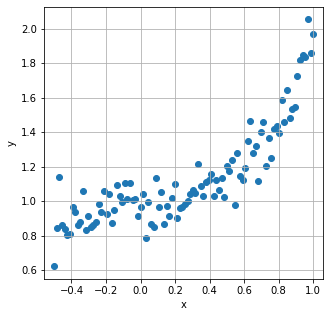

In [ ]:
dataset = pd.read_csv('dataEx5.csv')

x = dataset['x'].to_numpy()
x = np.reshape(x,(len(x),1))

y = dataset['y'].to_numpy()
y = np.reshape(y,(len(y),1))


fig = plt.figure(figsize=(5,5))
plt.scatter(x,y)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.grid('on')
plt.show()

In [ ]:
# DEGREE SELECTION
print("\nDEGREE SELECTION:\n")

max_deg = 30 # Max degree to try
min_err = 1e10
opt_deg = 0

for deg in range(max_deg+1):
  # Construct design matrix [1,x,x^2,x^3,...,x^deg]
  X_mat = constructDesignMatrix1D(x,deg)
  # Closed-form solution w/o regularisation
  w_cf = np.dot(np.linalg.inv(np.dot(X_mat.T, X_mat)), np.dot(X_mat.T, y))
  err = computeError(X_mat,y,w_cf)
  print(' DEGREE {}:'.format(deg))
  #print('w without regularisation = {}'.format(w_cf.T))
  print(' Error without regularisation = {}'.format(err))
  if(err < min_err ):
    min_err = err
    opt_deg = deg
  if(err > 1e4*min_err): # Arbitrary break when the error computed is so many times the min_err
    print(' Max error reached, stopping iterations...')
    break

print("\nMinimal error = {} reached with a {}-ith order regression.\n".format(min_err,opt_deg))





DEGREE SELECTION:

 DEGREE 0:
 Error without regularisation = [4.02975731]
 DEGREE 1:
 Error without regularisation = [1.23799315]
 DEGREE 2:
 Error without regularisation = [0.63508885]
 DEGREE 3:
 Error without regularisation = [0.42839779]
 DEGREE 4:
 Error without regularisation = [0.42585488]
 DEGREE 5:
 Error without regularisation = [0.41353337]
 DEGREE 6:
 Error without regularisation = [0.40747829]
 DEGREE 7:
 Error without regularisation = [0.40633073]
 DEGREE 8:
 Error without regularisation = [0.39454259]
 DEGREE 9:
 Error without regularisation = [0.38669445]
 DEGREE 10:
 Error without regularisation = [0.36115133]
 DEGREE 11:
 Error without regularisation = [0.35987602]
 DEGREE 12:
 Error without regularisation = [0.35918874]
 DEGREE 13:
 Error without regularisation = [0.35268113]
 DEGREE 14:
 Error without regularisation = [0.34198759]
 DEGREE 15:
 Error without regularisation = [0.33656193]
 DEGREE 16:
 Error without regularisation = [0.326186]
 DEGREE 17:
 Error with

After the execution we can see that the minimal error is obtained with the 17-ith degree polynomial, now we are going to compute that error with conjugate gradiente and with and without regularization.

4.17% (1/24) ALPHA:0.01 LAMBDA: 0.1
Error without regularisation = 0.43902463044126155
Error with regularisation = 0.828828603989926


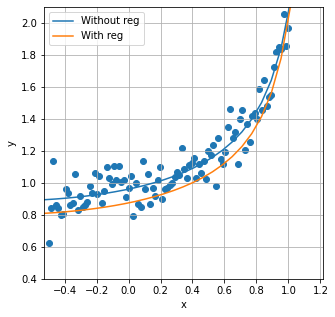

8.33% (2/24) ALPHA:0.1 LAMBDA: 0.1
Error without regularisation = 0.43756458942247933
Error with regularisation = 0.8272228836537824


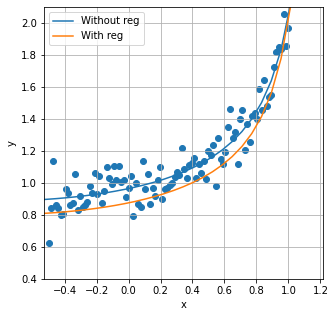

12.5% (3/24) ALPHA:0.3 LAMBDA: 0.1
Error without regularisation = 0.43021572098420735
Error with regularisation = 0.8270712419676536


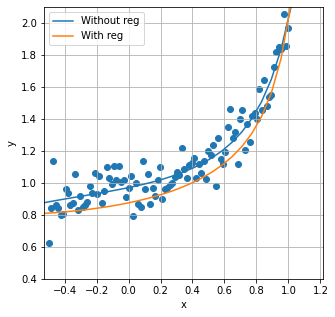

16.67% (4/24) ALPHA:0.5 LAMBDA: 0.1
Error without regularisation = 0.4275300598294241
Error with regularisation = 0.8270390313922691


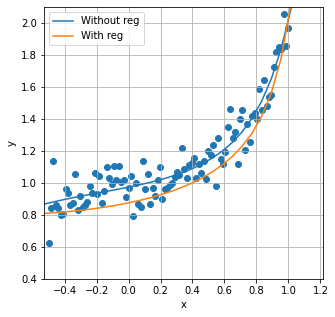

20.83% (5/24) ALPHA:0.8 LAMBDA: 0.1
Error without regularisation = 0.42561952423405636
Error with regularisation = 0.8269929242706552


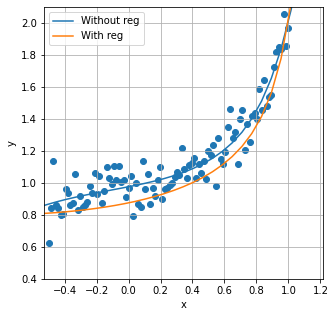

25.0% (6/24) ALPHA:1 LAMBDA: 0.1
Error without regularisation = 0.4247817316171179
Error with regularisation = 0.8269643724898296


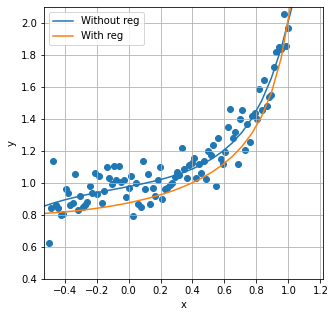

29.17% (7/24) ALPHA:0.01 LAMBDA: 0.0001
Error without regularisation = 0.43902463044126155
Error with regularisation = 0.4390377816654116


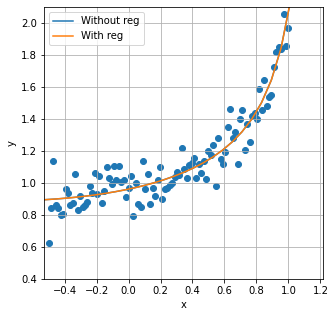

33.33% (8/24) ALPHA:0.1 LAMBDA: 0.0001
Error without regularisation = 0.43756458942247933
Error with regularisation = 0.4375576652256988


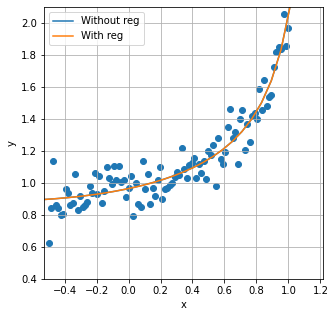

37.5% (9/24) ALPHA:0.3 LAMBDA: 0.0001
Error without regularisation = 0.43021572098420735
Error with regularisation = 0.43033219315163274


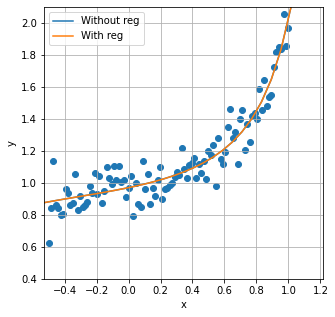

41.67% (10/24) ALPHA:0.5 LAMBDA: 0.0001
Error without regularisation = 0.4275300598294241
Error with regularisation = 0.4276831312866938


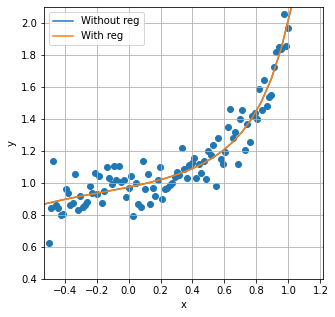

45.83% (11/24) ALPHA:0.8 LAMBDA: 0.0001
Error without regularisation = 0.42561952423405636
Error with regularisation = 0.4258056469821683


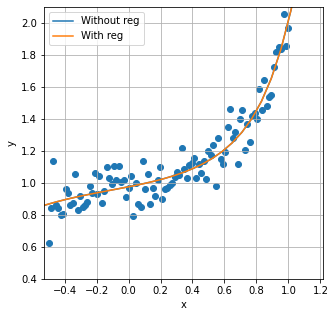

50.0% (12/24) ALPHA:1 LAMBDA: 0.0001
Error without regularisation = 0.4247817316171179
Error with regularisation = 0.42499526675763366


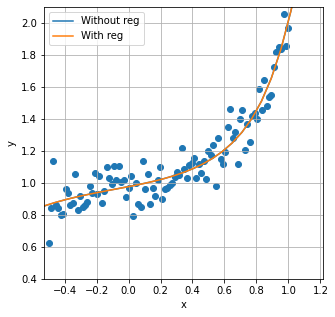

54.17% (13/24) ALPHA:0.01 LAMBDA: 1e-08
Error without regularisation = 0.43902463044126155
Error with regularisation = 0.43902463270647873


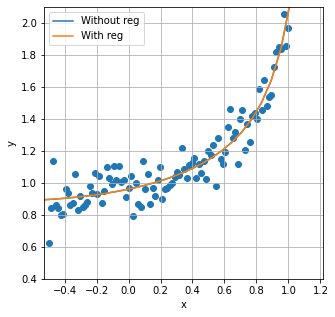

58.33% (14/24) ALPHA:0.1 LAMBDA: 1e-08
Error without regularisation = 0.43756458942247933
Error with regularisation = 0.4375645896783778


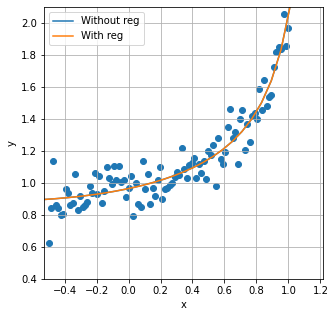

62.5% (15/24) ALPHA:0.3 LAMBDA: 1e-08
Error without regularisation = 0.43021572098420735
Error with regularisation = 0.4302157256521968


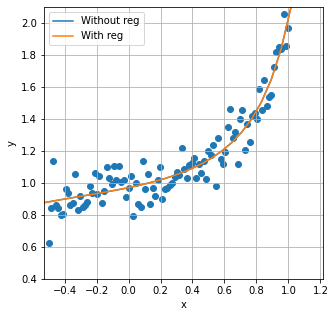

66.67% (16/24) ALPHA:0.5 LAMBDA: 1e-08
Error without regularisation = 0.4275300598294241
Error with regularisation = 0.4275300681763104


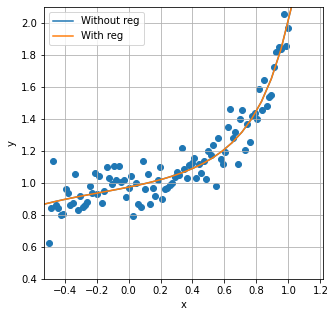

70.83% (17/24) ALPHA:0.8 LAMBDA: 1e-08
Error without regularisation = 0.42561952423405636
Error with regularisation = 0.42561953589426743


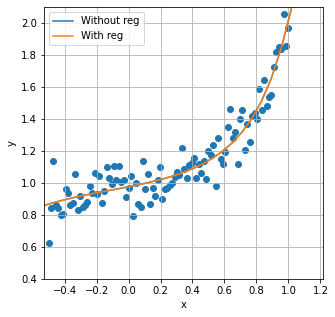

75.0% (18/24) ALPHA:1 LAMBDA: 1e-08
Error without regularisation = 0.4247817316171179
Error with regularisation = 0.4247817450202466


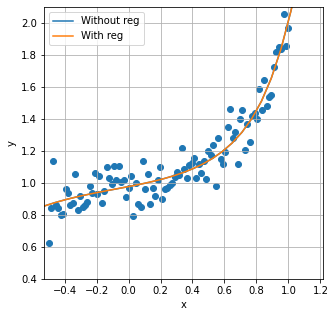

79.17% (19/24) ALPHA:0.01 LAMBDA: 1e-16
Error without regularisation = 0.43902463044126155
Error with regularisation = 0.43902463044126155


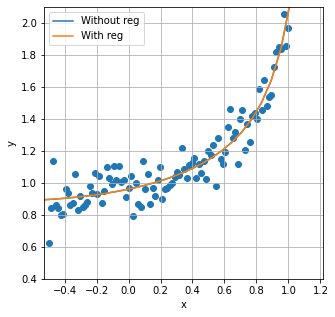

83.33% (20/24) ALPHA:0.1 LAMBDA: 1e-16
Error without regularisation = 0.43756458942247933
Error with regularisation = 0.43756458942247933


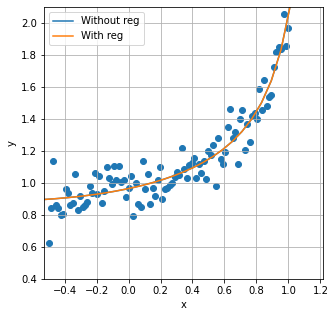

87.5% (21/24) ALPHA:0.3 LAMBDA: 1e-16
Error without regularisation = 0.43021572098420735
Error with regularisation = 0.43021572098420735


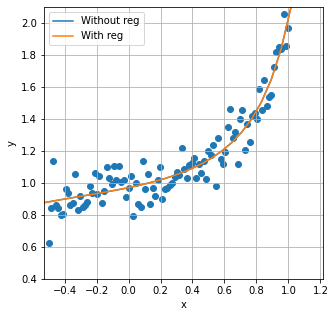

91.67% (22/24) ALPHA:0.5 LAMBDA: 1e-16
Error without regularisation = 0.4275300598294241
Error with regularisation = 0.42753005982942416


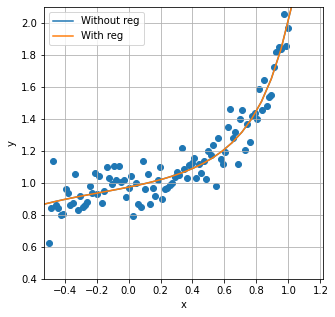

95.83% (23/24) ALPHA:0.8 LAMBDA: 1e-16
Error without regularisation = 0.42561952423405636
Error with regularisation = 0.42561952423405625


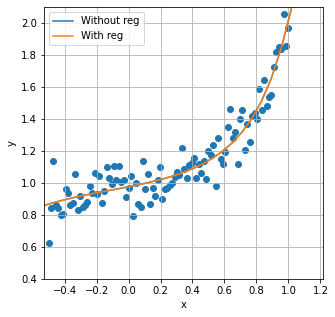

100.0% (24/24) ALPHA:1 LAMBDA: 1e-16
Error without regularisation = 0.4247817316171179
Error with regularisation = 0.42478173161711785


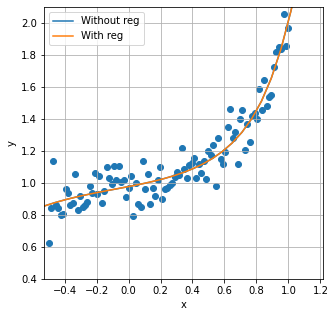

The minimal error is 0.42478173161711785 obtained with alpha = 1 and lambda = 1e-16
w without regularisation: [ 9.76799872e-01  1.94098818e-01  7.08468188e-02  2.80239479e-01
  8.15516272e-02  1.26102322e-01  6.75527750e-02  7.28249993e-02
  5.27368633e-02  4.85222712e-02  3.74767302e-02  2.99631541e-02
  2.02218357e-02  1.09641654e-02  8.01197148e-04 -9.48103882e-03
 -2.01528432e-02 -3.09343453e-02]
w with regularisation: [ 9.76799872e-01  1.94098818e-01  7.08468188e-02  2.80239479e-01
  8.15516272e-02  1.26102322e-01  6.75527750e-02  7.28249993e-02
  5.27368633e-02  4.85222712e-02  3.74767302e-02  2.99631541e-02
  2.02218357e-02  1.09641654e-02  8.01197148e-04 -9.48103882e-03
 -2.01528432e-02 -3.09343453e-02]


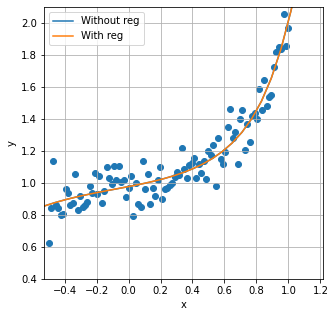

In [ ]:
# Construct design matrix [1,x,x^2,x^3,...,x^deg]
X_mat = constructDesignMatrix1D(x,opt_deg)
# Create a initial w coefficients matrix
w0 = np.zeros((opt_deg+1,1))
lRegs = [0.1, 1e-4, 1e-8, 1e-16]
alphas = [0.01, 0.1, 0.3, 0.5, 0.8, 1]
nIts = 5000
total_its = len(lRegs)*len(alphas) # Proving parameters iterations
it = 0 # Current iteration
tol = 1e-5


# Initialize min variables
min_Rerror = 1e4
opt_Ralpha = 0
opt_Rlambda = 0
min_error = 1e4
opt_alpha = 0

# Looking for best lambda and alpha
for lReg in lRegs:
  for alpha in alphas:
    it += 1
    print("{}% ({}/{}) ALPHA:{} LAMBDA: {}".format(round(it/total_its*100,2),it,total_its,alpha,lReg))

    # Obtain coefficients w with and without regularisation
    w_vec, error_vec = gradientDescent_RidgeReg(X_mat, y, w0, alpha, 0, nIts, tol)
    wReg_vec, errorReg_vec = gradientDescent_RidgeReg(X_mat, y, w0, alpha, lReg, nIts, tol)



    # Saving best parameters
    error = error_vec[-1]
    Rerror = errorReg_vec[-1]

    if(error < min_error):
      min_error = error
      opt_alpha = alpha
      opt_lambda = 0
      opt_w = w_vec

    if(Rerror < min_Rerror):
      min_Rerror = Rerror
      opt_Ralpha = alpha
      opt_Rlambda = lReg
      opt_Rw = wReg_vec


    print('Error without regularisation = {}'.format( error ) )
    print('Error with regularisation = {}'.format( Rerror ) )

    # Models plot
    fig = plt.figure(figsize=(5,5))
    plt.scatter(x,y)
    plotModel1D(w_vec[:,-1],x)
    plotModel1D(wReg_vec[:,-1],x)
    plt.axis('equal')
    plt.grid('on')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Without reg', 'With reg'])
    plt.ylim(0.4,2.1)
    plt.xlim(-0.51,1.2)
    plt.show()

# Choosing between regularisation or not
if(min_Rerror < min_error):
  min_error = min_Rerror
  opt_alpha = opt_Ralpha
  opt_lambda = opt_Rlambda # If min_Rerror > min_error opt_lambda value would remain at 0

print("The minimal error is {} obtained with alpha = {} and lambda = {}".format(min_error,opt_alpha,opt_lambda))
print('w without regularisation: {}'.format(w_vec[:,-1]))
print('w with regularisation: {}'.format(wReg_vec[:,-1]))

# Models plot
fig = plt.figure(figsize=(5,5))
plt.scatter(x,y)
plotModel1D(w_vec[:,-1],x)
plotModel1D(wReg_vec[:,-1],x)
plt.axis('equal')
plt.grid('on')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Without reg', 'With reg'])
plt.ylim(0.4,2.1)
plt.xlim(-0.51,1.2)
plt.show()



After seeing this plots we can say that the minimal error is reached with a lambda near to 0 (1e-16), what means that is like a non-regularised regression. Also with the previous iterations we can see that a bigger alpha, learning rate, provides a better data-fit. With the previous plot we can confirm that both regressions (with reg and without reg), are the same due to the small lambda value. If we compare the smallest error reached with conjugate gradient with the one of the closed solution, we can clearly see that the closed one is the minimum, this is a reasonable result because in conjugate gradient we are computing an aproximation. If we optmize even more the parameters we could maybe reach the close solution minimum.